In [ ]:
!pip install pycuda -q

import pycuda.autoinit
import pycuda.driver as drv

import numpy as np
from pycuda.compiler import SourceModule

本例通过 linear_fwd kernel 来实现矩阵乘和 biasadd 计算，为 attention layer 生成 KQV tensors：(bs, n_seq, n_hidden) -> (bs, n_seq, 3 * n_hidden)

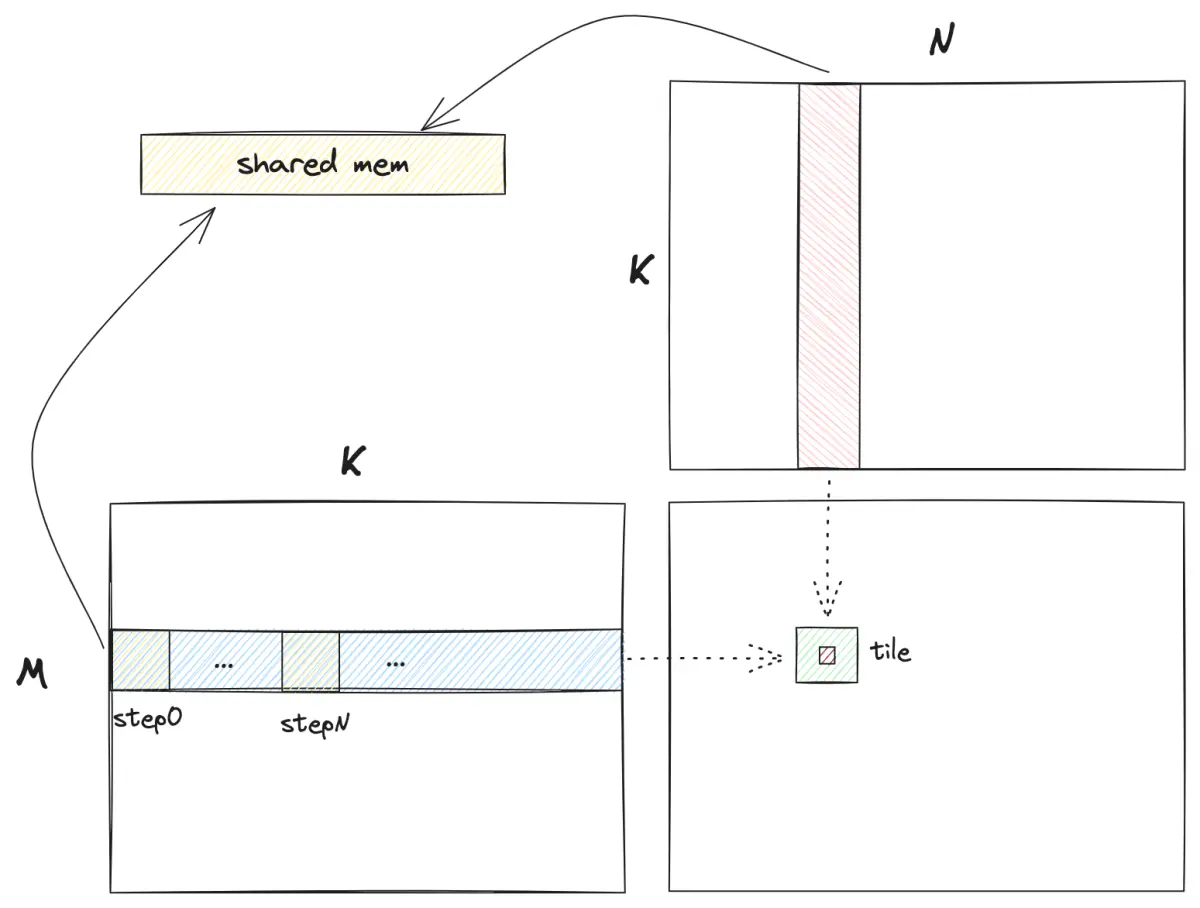




矩阵乘（GEMM）kernel 的实现大致包括以下内容：
- 计算 M/N 维度上的 tile size
  - 一个 thread 计算 8 * 8 大小的 output elements，一个 block 有 16 * 16 个线程，那一个 block 生成的 output tile 是 128 * 128 elements。
  - 确定了 output tile shape，那 LHS 和 RHS 的 tile shape 也确定了：128 * K, 128 * K。
- 计算 K 维度上的 tile size
  - 由于计算时，LHS/RHS tile 的同一区域会被不同线程反复加载，因此，将它们存储在 shared memory 上可以提高线程的读取效率。
  - 但由于 shared memory 大小是有限的，可能无法放下 2 * 128 * K 大小的数据，因此，就需要在 K 维度做切分，通过循环迭代的方式来计算。
  - 这里的 K tile size = 4，可以通过 vector 读写的方式来提高访存性能。
- 计算 grid size

  一个 block 计算生成一个 ouput tile，row/col 的 tile_size 是一样的，16 * 8 = 128。
  ```
  tile_size = 16
  grid_size0 = int(np.ceil(bs * n_seq / (8 * tile_size)))
  grid_size1 = int(np.ceil(NH3 / (8 * tile_size)))
  grid_size = (grid_size0, grid_size1, 1)
  block_size = (tile_size, tile_size, 1)
  ```
- 计算 LHS/RHS tile shared memory size

  结合 block 在 M/N 维度的 tile size: (128 * 128)，每个线程的 tile size:（8 * 8），以及 K tile size：4，可以计算出 shared memory：
  ```
  // M: 16(threads in y dim) * 8(per thread) = 128 elements, K: 8(per thread) * 4(per vector) = 32 elements per step
  __shared__ float lhs_smem[128][8*4];
  // N: 16(threads in y dim) * 8(per thread) = 128 elements, K: 8(per thread) * 4(per vector) = 32 elements per step
  __shared__ float rhs_smem[128][8*4];
  ```
- 初始化 bias

  bias 如果存在的话，相当于 GEMM 里的 C 矩阵，需要将 blockIdx.y 映射到 bias 的一维向量位置来获取当前线程所需的 8x8 大小的bias data：
  ```
  int oc_idx = (blockIdx.y * blockDim.y + threadIdx.y) * 8;
  if (bias) {
    for (int i = 0; i < 8; i++) {
      for (int j = 0; j < 8; j += 4) {
        float4 tmp = load_vector(bias + oc_idx + j);
  ```
- load LHS/RHS tile to shared memory

  程序会循环迭代 K 维度上的 tile，block 里的线程需要在每个 step 一起合作将 tile 加载到 shared memory，后续各线程再从 shared memory 里加载各自所需 data 做计算。
  ```
    for (int y = 2 * threadIdx.y + threadIdx.x / 8; y < 128; y += 32) {
      int in_x = threadIdx.x % 8 * 4;
      store_vector(&lhs_smem[y][in_x], load_vector(lhs + y * C + iter_start + in_x));
      store_vector(&rhs_smem[y][in_x], load_vector(rhs_w + y * C + iter_start + in_x));
    }
  ```
- 矩阵乘

  K 维度的上的每个 step，线程的计算结果会累加到它 8x8 大小的本地变量。

- 写回 output tensor
  经历完 K 维度的循环后，将 8x8 大小的本地变量写回到它在 output tensor 的相对位置中。

In [ ]:
bs = 4            # batch size
n_seq = 512       # sequence len
n_cxt = 1024      # max context len
n_hidden = 768    # hidden size
n_vocab = 50237   # vocab_size

np.random.seed(42)
NH3 = n_hidden * 3
input = np.random.randn(bs, n_seq, n_hidden).astype(np.float32)
qkv_w = np.random.randn(NH3, n_hidden).astype(np.float32)
qkv_b = np.random.randn(NH3).astype(np.float32)
out = np.empty((bs, n_seq, NH3), dtype=np.float32)

prog = SourceModule("""
__device__ inline float4 load_vector(const float *addr) {
  return *reinterpret_cast<const float4 *>(addr);
}

__device__ inline void store_vector(float *addr, float4 val) {
  *reinterpret_cast<float4 *>(addr) = val;
}

__global__ void linear_fwd(float *out, const float *inp, const float *weight, const float *bias, int B, int T, int OC, int C) {
  // M: 16(threads in y dim) * 8(per thread) = 128 elements, K: 8(per thread) * 4(per vector) = 32 elements per step
  __shared__ float lhs_smem[128][8*4];
  // N: 16(threads in y dim) * 8(per thread) = 128 elements, K: 8(per thread) * 4(per vector) = 32 elements per step
  __shared__ float rhs_smem[128][8*4];

  float *lhs = (float*)inp + 128 * blockIdx.x * C;
  float *rhs_w = (float*)weight + 128 * blockIdx.y * C;
  out += 128 * blockIdx.x * OC + 128 * blockIdx.y;

  // load bias to acc local memory
  float val[8][8] = {};
  int oc_idx = (blockIdx.y * blockDim.y + threadIdx.y) * 8;
  if (bias) {
    for (int i = 0; i < 8; i++) {
      for (int j = 0; j < 8; j += 4) {
        float4 tmp = load_vector(bias + oc_idx + j);
        val[i][j+0] = tmp.x;
        val[i][j+1] = tmp.y;
        val[i][j+2] = tmp.z;
        val[i][j+3] = tmp.w;
      }
    }
  }

  int idx = 4 * (threadIdx.y * 16 + threadIdx.x);
  for (int iter_start = 0; iter_start < C; iter_start += 32) {
    __syncthreads();
    // load weight and inp to smem
    for (int y = 2 * threadIdx.y + threadIdx.x / 8; y < 128; y += 32) {
      int in_x = threadIdx.x % 8 * 4;
      store_vector(&lhs_smem[y][in_x], load_vector(lhs + y * C + iter_start + in_x));
      store_vector(&rhs_smem[y][in_x], load_vector(rhs_w + y * C + iter_start + in_x));
    }
    __syncthreads();

    // matmul
    for (int si = idx; si < idx + 32; si += 4) {
      float4 _rhs[8];
      for (int u = 0; u < 8; u++) {
        _rhs[u] = load_vector(&rhs_smem[threadIdx.y * 8 + u][si % 32]);
      }

      for (int i = 0; i < 8; i++) {
        float4 _lhs = load_vector(&lhs_smem[threadIdx.x * 8 + i][si % 32]);
        for (int j = 0; j < 8; j++) {
          val[i][j] += _lhs.x * _rhs[j].x;
          val[i][j] += _lhs.y * _rhs[j].y;
          val[i][j] += _lhs.z * _rhs[j].z;
          val[i][j] += _lhs.w * _rhs[j].w;
        }
      }
    }

    for (int i = 0; i < 8; i++) {
      for (int j = 0; j < 8; j += 4) {
        float4 tmp;
        tmp.x = val[i][j+0];
        tmp.y = val[i][j+1];
        tmp.z = val[i][j+2];
        tmp.w = val[i][j+3];
        store_vector(out + (8 * threadIdx.x + i) * OC + (8 * threadIdx.y + j), tmp);
      }
    }
  }
}
""")

In [ ]:
matmul_fwd = prog.get_function("linear_fwd")

tile_size = 16
grid_size0 = int(np.ceil(bs * n_seq / (8 * tile_size)))
grid_size1 = int(np.ceil(NH3 / (8 * tile_size)))
grid_size = (grid_size0, grid_size1, 1)
block_size = (tile_size, tile_size, 1)
matmul_fwd(drv.Out(out), drv.In(input), drv.In(qkv_w), drv.In(qkv_b), np.int32(bs), np.int32(n_seq), np.int32(NH3), np.int32(n_hidden), block=block_size, grid=grid_size)

验证计算结果：

In [ ]:
def ref_linear_fwd(input, weight, bias):
  return input @ weight.T + bias

np.allclose(out, ref_linear_fwd(input, qkv_w, qkv_b), atol=1e-4, rtol=1e-5)

/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


True